# A/B Testing for Optimizing E-Commerce Landing Pages
by Edycakra Immanuel Sinaga

In [7]:
#import dependencies
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline

In [11]:
#read the dataset
df = pd.read_csv('../data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [18]:
#check duplicates 
df.duplicated().sum()

0

In [25]:
#check for duplicates on the user_id column
duplicates = df.duplicated(subset=['user_id'], keep=False)

#print the duplicate rows
print(df[duplicates].sort_values(by='user_id'))

        user_id                   timestamp      group landing_page  converted
230259   630052  2017-01-17 01:16:05.208766  treatment     new_page          0
213114   630052  2017-01-07 12:25:54.089486  treatment     old_page          1
22513    630126  2017-01-14 13:35:54.778695  treatment     old_page          0
251762   630126  2017-01-19 17:16:00.280440  treatment     new_page          0
183371   630137  2017-01-20 02:08:49.893878    control     old_page          0
...         ...                         ...        ...          ...        ...
142354   945703  2017-01-08 19:40:51.169351    control     new_page          0
186960   945797  2017-01-13 17:23:21.750962    control     old_page          0
40370    945797  2017-01-11 03:04:49.433736    control     new_page          1
165143   945971  2017-01-16 10:09:18.383183    control     old_page          0
131756   945971  2017-01-22 12:43:54.087275    control     new_page          0

[7788 rows x 5 columns]


In [29]:
#new df where user_id is unique
df_unique = df.drop_duplicates(subset=['user_id'])

#check for duplicates on the user_id column
duplicates = df_unique.duplicated(subset=['user_id'], keep=False)

#print the duplicate rows
print(df_unique[duplicates].sort_values(by='user_id'))

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []


In [49]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [50]:
df_unique.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [31]:
#check the control and treatment
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [32]:
#check missing values
df.isnull().sum()


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### Calculate the Sample Size

In [33]:
#we want to have 2% progress of conversion from previous 12% on old page
effect_size = sms.proportion_effectsize(0.12, 0.14)    

#power of a test usually set to 0.8
#alpha = 0.05
required_sample = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
)

#round it
required_sample = ceil(required_sample)                     

print("Sample needed from each group:", required_sample)

Sample needed from each group: 4433


Sampling from both group and control using fixed random_state

In [35]:
#sampling with fixed random_state so the data to ensure reproducibility

control_new = df_unique[df_unique['group'] == 'control'].sample(n=required_sample, random_state=7)
treatment_new = df_unique[df_unique['group'] == 'treatment'].sample(n=required_sample, random_state=7)

ab_test = pd.concat([control_new, treatment_new], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test

,user_id,timestamp,group,landing_page,converted
0,778243,2017-01-19 16:14:26.292281,control,old_page,0
1,843034,2017-01-22 00:03:12.061165,control,old_page,0
2,936218,2017-01-12 18:16:10.518334,control,old_page,0
3,929296,2017-01-11 22:26:43.161061,control,old_page,1
4,814775,2017-01-03 23:01:57.969597,control,old_page,0
...,...,...,...,...,...
8861,832753,2017-01-16 23:47:55.837432,treatment,new_page,0
8862,746946,2017-01-21 17:17:04.868867,treatment,new_page,0
8863,643301,2017-01-20 02:44:25.880400,treatment,new_page,0
8864,944265,2017-01-20 15:29:45.141502,treatment,new_page,0


In [36]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8866 entries, 0 to 8865
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       8866 non-null   int64 
 1   timestamp     8866 non-null   object
 2   group         8866 non-null   object
 3   landing_page  8866 non-null   object
 4   converted     8866 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 346.5+ KB


In [37]:
ab_test['group'].value_counts()

control      4433
treatment    4433
Name: group, dtype: int64

In [38]:
ab_test['landing_page'].value_counts()

new_page    4438
old_page    4428
Name: landing_page, dtype: int64

### Result

In [41]:
conversion_rates = ab_test.groupby('group')['converted']

# Std. deviation of the proportion
std_p = lambda x: np.std(x)  

# Std. error of the proportion 
se_p = lambda x: stats.sem(x)            

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates

,conversion_rate,std_deviation,std_error
group,,,
control,0.124295,0.329918,0.004956
treatment,0.110986,0.314115,0.004718


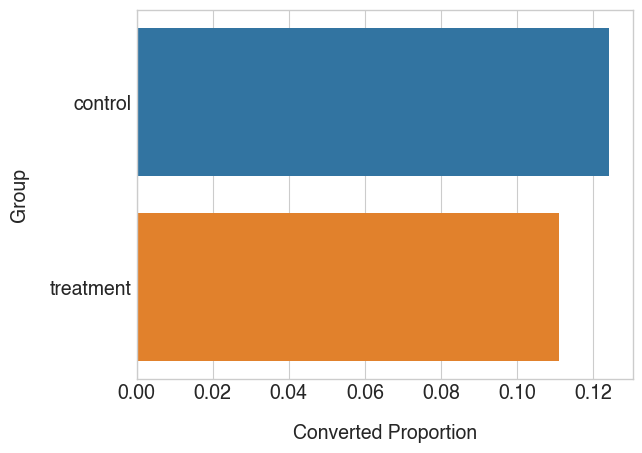

In [47]:
#visualize the result
plt.figure()

sns.barplot(x=ab_test['converted'], y=ab_test['group'], errorbar=('ci', False))

plt.xlabel('Converted Proportion', labelpad=15)
plt.ylabel('Group', labelpad=15)
plt.show()


### Hypothesis Testing

In [51]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

#select the conversion results for the control group
control_results = ab_test[ab_test['group'] == 'control']['converted']

#select the conversion results for the treatment group
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

#get the sample sizes for both groups
n_con = control_results.count()
n_treat = treatment_results.count()

#get the number of conversions for both groups
successes = [control_results.sum(), treatment_results.sum()]

#put the sample sizes and number of conversions into the format required by statsmodels proportions_ztest function
nobs = [n_con, n_treat]

#calculate the z-statistic and p-value
z_stat, pval = proportions_ztest(successes, nobs=nobs)

#calculate the 95% confidence intervals for the conversion rates
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.3f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.945
p-value: 0.052
ci 95% for control group: [0.115, 0.134]
ci 95% for treatment group: [0.102, 0.120]


### Conclusions

- The conversion rate for the control group is 12.43% and for the treatment group is 11.10%
- The z-statistic is 1.94, which is less than the critical value of 1.96 for a significance level of 0.05. Therefore, we fail to reject the null hypothesis, which means that there is no statistically significant difference in conversion rates between the old and new landing pages.
- The p-value is 0.052, which is greater than the significance level of 0.05. This confirms that there is not enough evidence to reject the null hypothesis
- The 95% confidence intervals for control groups shows that we can be 95% confident that the true conversion rate of the control group is somewhere between 11.5% and 13.4%
- The 95% confidence intervals for treatment groups does not overlap with the desired 14% conversion rate, which further supports the conclusion that the new landing page did not result in a significant improvement in conversion rates
- Overall, the A/B testing did not show a significant improvement in conversion rates from 12% to 14%, and it is recommended to keep the old landing page